<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>May 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@etu.u-paris.fr</span>
</p>
</CENTER>

## <span id="section-0" style="color:#00B8DE"> 0 - Imports & Parameters </span>

In [117]:
import  warnings
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
from    scipy.stats             import  norm, johnsonsu, johnsonsb, lognorm
from    scipy.special           import  eval_genlaguerre
from    sklearn.linear_model    import  LinearRegression
import  statsmodels.api         as      sm
import  pandas                  as      pd
from    scipy.interpolate       import  interp1d
import  seaborn                 as      sns
from    math                    import  sqrt, exp
from    j_johnson_M             import  f_johnson_M

np.random.seed(3)
plt.style.use('ggplot')

In [118]:
color_jlsmc = 'blue'
color_glsmc = 'red'

In [119]:
r           = 0.05
S0          = 100
sigma       = 0.3
T           = 1
delta       = 1/24  # 10 business days, ie. 2 weeks
dt          = 1/240 # 1 business day

time_grid   = np.arange(0, T, dt)
N           = len(time_grid)-1
M           = 200000
tref        = 1/12 # 1 week
ind_tref    = int(tref/dt)
ind_delta   = int(delta/dt)
ind_tdelta  = int((tref+delta)/dt)
Sref        = 100

alpha       = 0.99
K           = 95

def beta(t):
    return np.exp(-r*t)

In [120]:
def gen_S(S0, M, N):
    paths           = np.zeros((M, N+1))
    paths[:, 0]     = S0
    Z               = np.random.normal(0, 1, size=(M, N))
    increments      = np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    paths[:, 1:]    = S0 * np.cumprod(increments, axis=1)
    return paths

S_paths = gen_S(S0, M, N)

In [121]:
def gen_mtm_put(S_paths, time_grid):
    M   = S_paths.shape[0]
    N   = S_paths.shape[1]-1
    mtm = np.zeros((M, N+1))
    for i in range(N+1):
        d1          = (np.log(S_paths[:, i]/K) + (r + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm[:, i]   = K*beta(T-time_grid[i])*norm.cdf(-d2) - S_paths[:, i]*norm.cdf(-d1)
        
    return mtm

mtm_paths       = gen_mtm_put(S_paths, time_grid)
mtm_diff_paths  = mtm_paths[:, ind_delta:] - mtm_paths[:, :-ind_delta]
mtm_ref         = gen_mtm_put(np.array([[Sref]]), time_grid[ind_tref:ind_tref+1])[0][0]

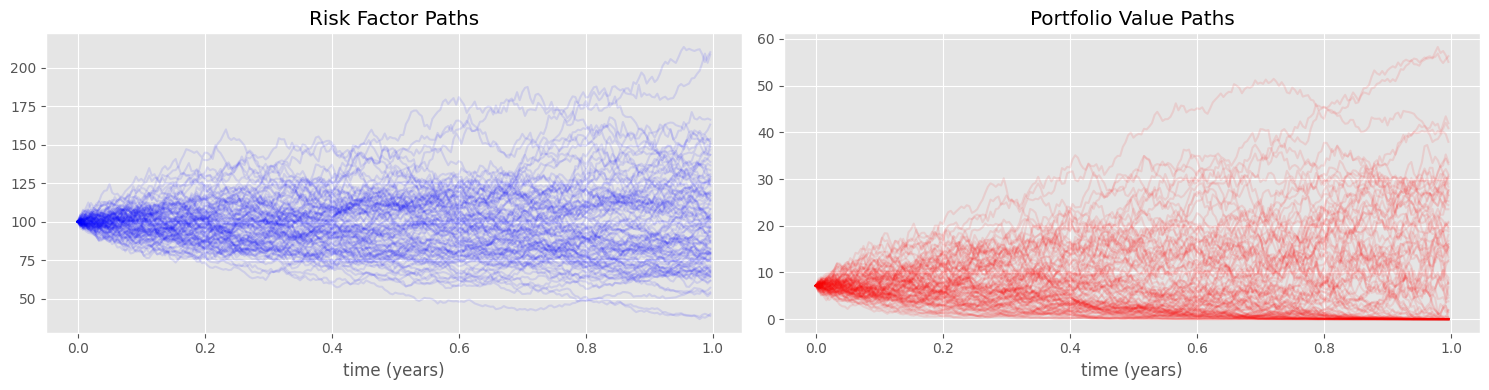

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(time_grid, S_paths[:100, :].T, color='blue', alpha=0.1)
axs[0].set_title('Risk Factor Paths')
axs[0].set_xlabel('time (years)')
axs[1].plot(time_grid, mtm_paths[:100, :].T, color='red', alpha=0.1)
axs[1].set_title('Portfolio Value Paths')
axs[1].set_xlabel('time (years)')
plt.tight_layout()
plt.show()

In [123]:
Nq      = 200
Nq_tail = int(0.1*Nq)//2

q_main              = np.arange(1, Nq) / Nq
q_ltail             = np.linspace(0, 0.01, Nq_tail+2)[1:-1]
q_utail             = np.linspace(0.99, 1, Nq_tail+2)[1:-1]
q_all               = np.sort(np.unique(np.concatenate([q_ltail, q_main, q_utail])))
sample_quantiles    = np.quantile(mtm_paths[:, ind_tref], q_all)

In [124]:
S_jlsmc     = 2
S_glsmc     = 2
X_jlsmc     = np.column_stack([eval_genlaguerre(s, 0, mtm_paths[:, ind_tref]) for s in range(S_jlsmc+1)])
X_glsmc     = np.column_stack([mtm_paths[:, ind_tref]**r for r in range(S_glsmc+1)])

mtm_test        = np.linspace(np.min(mtm_paths[:, ind_tref]), np.max(mtm_paths[:, ind_tref]), 1000)
X_test_jlsmc    = np.column_stack([eval_genlaguerre(s, 0, mtm_test) for s in range(S_jlsmc+1)])
X_ref_jlsmc     = np.column_stack([eval_genlaguerre(s, 0, np.array([mtm_ref])) for s in range(S_jlsmc+1)])
X_test_glsmc    = np.column_stack([mtm_test**r for r in range(S_glsmc+1)])
X_ref_glsmc     = np.column_stack([np.array([mtm_ref])**r for r in range(S_glsmc+1)])

X_quant_jlsmc = np.column_stack([eval_genlaguerre(s, 0, sample_quantiles) for s in range(S_jlsmc+1)])

order_mom = 4
y_hat_jlsmc = np.zeros((X_test_jlsmc.shape[0], order_mom+1))
moms_quant_jlsmc = np.zeros((len(sample_quantiles), order_mom+1))
moms_ref_jlsmc = np.zeros(order_mom+1)
for j in range(1, order_mom+1):
    y = mtm_diff_paths[:, ind_tref]**j
    if j%2 != 0:
        model                       = LinearRegression(fit_intercept=False)
        model.fit(X_jlsmc, y)
        y_hat_jlsmc[:, j-1]         = model.predict(X_test_jlsmc)
        moms_quant_jlsmc[:, j-1]    = model.predict(X_quant_jlsmc)
        moms_ref_jlsmc[j-1]         = model.predict(X_ref_jlsmc)[0]


    else:
        glm                         = sm.GLM(y, X_jlsmc, family=sm.families.Gaussian(sm.families.links.Log())).fit()
        y_hat_jlsmc[:, j-1]         = glm.predict(X_test_jlsmc)
        moms_quant_jlsmc[:, j-1]    = glm.predict(X_quant_jlsmc)
        moms_ref_jlsmc[j-1]         = glm.predict(X_ref_jlsmc)[0]

'''
model       = LinearRegression(fit_intercept=False)
model.fit(X_glsmc, mtm_diff_paths[:, ind_tref]**2)
y_hat_glsmc = model.predict(X_test_glsmc)
'''
glm                 = sm.GLM(mtm_diff_paths[:, ind_tref]**2, X_glsmc, family=sm.families.Gaussian(sm.families.links.Log())).fit()
y_hat_glsmc         = glm.predict(X_test_glsmc)
mom2_ref_glsmc      = glm.predict(X_ref_glsmc)[0]

In [125]:
mu1_test_jlsmc  = y_hat_jlsmc[:, 0]
mu1_test_glsmc  = np.zeros_like(mtm_test)
mu1_quant_jlsmc = moms_quant_jlsmc[:, 0]
mu1_ref_jlsmc   = moms_ref_jlsmc[0]

mu2_test_jlsmc  = y_hat_jlsmc[:, 1] - y_hat_jlsmc[:, 0]**2
mu2_test_glsmc  = y_hat_glsmc
mu2_quant_jlsmc = moms_quant_jlsmc[:, 1] - moms_quant_jlsmc[:, 0]**2
mu2_ref_jlsmc   = moms_ref_jlsmc[1] - moms_ref_jlsmc[0]**2
mu2_ref_glsmc   = mom2_ref_glsmc

mu3_test_jlsmc  = y_hat_jlsmc[:, 2] - 3*y_hat_jlsmc[:, 0]*y_hat_jlsmc[:, 1] + 2*y_hat_jlsmc[:, 0]**3
mu3_test_glsmc  = np.zeros_like(mtm_test)
mu3_quant_jlsmc = moms_quant_jlsmc[:, 2] - 3*moms_quant_jlsmc[:, 0]*moms_quant_jlsmc[:, 1] + 2*moms_quant_jlsmc[:, 0]**3
mu3_ref_jlsmc   = moms_ref_jlsmc[2] - 3*moms_ref_jlsmc[0]*moms_ref_jlsmc[1] + 2*moms_ref_jlsmc[0]**3

mu4_test_jlsmc  = y_hat_jlsmc[:, 3] - 4*y_hat_jlsmc[:, 0]*y_hat_jlsmc[:, 2] + 6*y_hat_jlsmc[:, 0]**2*y_hat_jlsmc[:, 1] - 3*y_hat_jlsmc[:, 0]**4
mu4_test_glsmc  = 3*y_hat_glsmc**2
mu4_quant_jlsmc = moms_quant_jlsmc[:, 3] - 4*moms_quant_jlsmc[:, 0]*moms_quant_jlsmc[:, 2] + 6*moms_quant_jlsmc[:, 0]**2*moms_quant_jlsmc[:, 1] - 3*moms_quant_jlsmc[:, 0]**4
mu4_ref_jlsmc   = moms_ref_jlsmc[3] - 4*moms_ref_jlsmc[0]*moms_ref_jlsmc[2] + 6*moms_ref_jlsmc[0]**2*moms_ref_jlsmc[1] - 3*moms_ref_jlsmc[0]**4


mask_test_jlsmc     = (mu2_test_jlsmc > 0) & (mu4_test_jlsmc > 0)

skew_test_jlsmc     = mu3_test_jlsmc[mask_test_jlsmc] / mu2_test_jlsmc[mask_test_jlsmc]**(3/2)
skew_test_glsmc     = mu3_test_glsmc / mu2_test_glsmc**(3/2)
skew_quant_jlsmc    = mu3_quant_jlsmc / mu2_quant_jlsmc**(3/2)
skew_ref_jlsmc      = mu3_ref_jlsmc / mu2_ref_jlsmc**(3/2)

kurt_test_jlsmc     = mu4_test_jlsmc[mask_test_jlsmc] / mu2_test_jlsmc[mask_test_jlsmc]**2
kurt_test_glsmc     = mu4_test_glsmc / mu2_test_glsmc**2
kurt_quant_jlsmc    = mu4_quant_jlsmc / mu2_quant_jlsmc**2
kurt_ref_jlsmc      = mu4_ref_jlsmc / mu2_ref_jlsmc**2

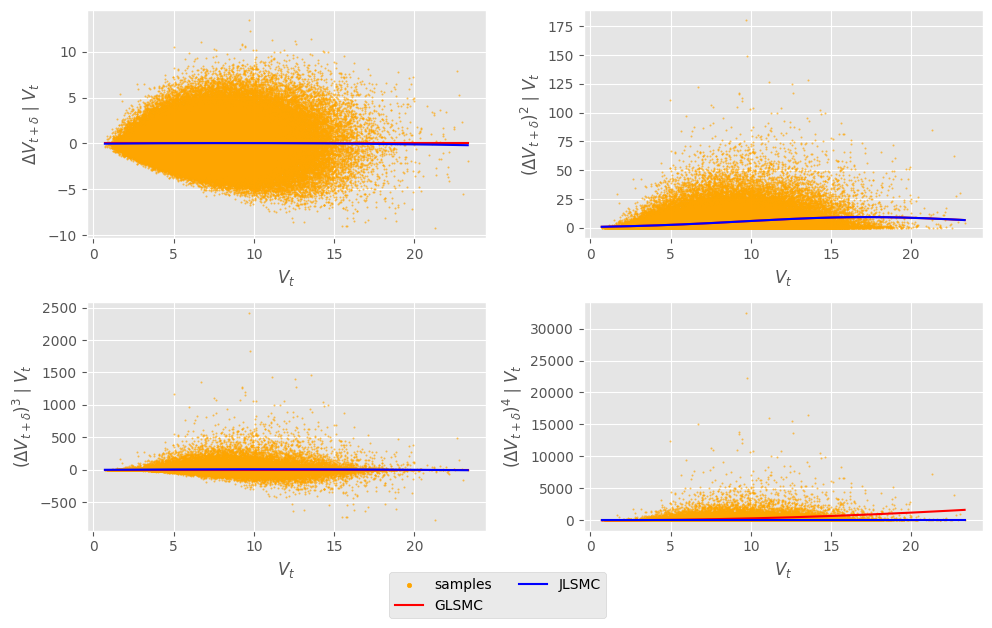

In [126]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].scatter(mtm_paths[:, ind_tref], mtm_diff_paths[:, ind_tref], alpha=0.5, s=1, color='orange')
axs[0, 0].scatter([None], [None], s=10, color='orange', label='samples')
axs[0, 0].plot(mtm_test, np.zeros_like(mtm_test), color=color_glsmc, label='GLSMC')
axs[0, 0].plot(mtm_test, y_hat_jlsmc[:, 0], color=color_jlsmc, label='JLSMC')
#axs[0, 0].scatter(sample_quantiles, moms_quant_jlsmc[:, 0], s=10, color='red', label='JLSMC quantiles')
axs[0, 0].set_xlabel('$V_t$')
axs[0, 0].set_ylabel('$\\Delta V_{t+\\delta} \\mid V_t$')

axs[0, 1].scatter(mtm_paths[:, ind_tref], mtm_diff_paths[:, ind_tref]**2, alpha=0.5, s=1, color='orange')
axs[0, 1].plot(mtm_test, y_hat_glsmc, color=color_glsmc, label='GLSMC')
axs[0, 1].plot(mtm_test, y_hat_jlsmc[:, 1], color=color_jlsmc, label='JLSMC')
#axs[0, 1].scatter(sample_quantiles, moms_quant_jlsmc[:, 1], s=10, color='red', label='JLSMC quantiles')
axs[0, 1].set_xlabel('$V_t$')
axs[0, 1].set_ylabel('$\\left(\\Delta V_{t+\\delta}\\right)^2 \\mid V_t$')

axs[1, 0].scatter(mtm_paths[:, ind_tref], mtm_diff_paths[:, ind_tref]**3, alpha=0.5, s=1, color='orange')
axs[1, 0].plot(mtm_test, np.zeros_like(mtm_test), color=color_glsmc, label='GLSMC')
axs[1, 0].plot(mtm_test, y_hat_jlsmc[:, 2], color=color_jlsmc, label='JLSMC')
#axs[1, 0].scatter(sample_quantiles, moms_quant_jlsmc[:, 2], s=10, color='red', label='JLSMC quantiles')
axs[1, 0].set_xlabel('$V_t$')
axs[1, 0].set_ylabel('$\\left(\\Delta V_{t+\\delta}\\right)^3 \\mid V_t$')

axs[1, 1].scatter(mtm_paths[:, ind_tref], mtm_diff_paths[:, ind_tref]**4, alpha=0.5, s=1, color='orange')
axs[1, 1].plot(mtm_test, 3*mtm_test**2, color=color_glsmc, label='GLSMC')
axs[1, 1].plot(mtm_test, y_hat_jlsmc[:, 4], color=color_jlsmc, label='JLSMC')
# axs[1, 1].scatter(sample_quantiles, moms_quant_jlsmc[:, 4], s=10, color='red', label='JLSMC quantiles')
axs[1, 1].set_xlabel('$V_t$')
axs[1, 1].set_ylabel('$\\left(\\Delta V_{t+\\delta}\\right)^4 \\mid V_t$')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()

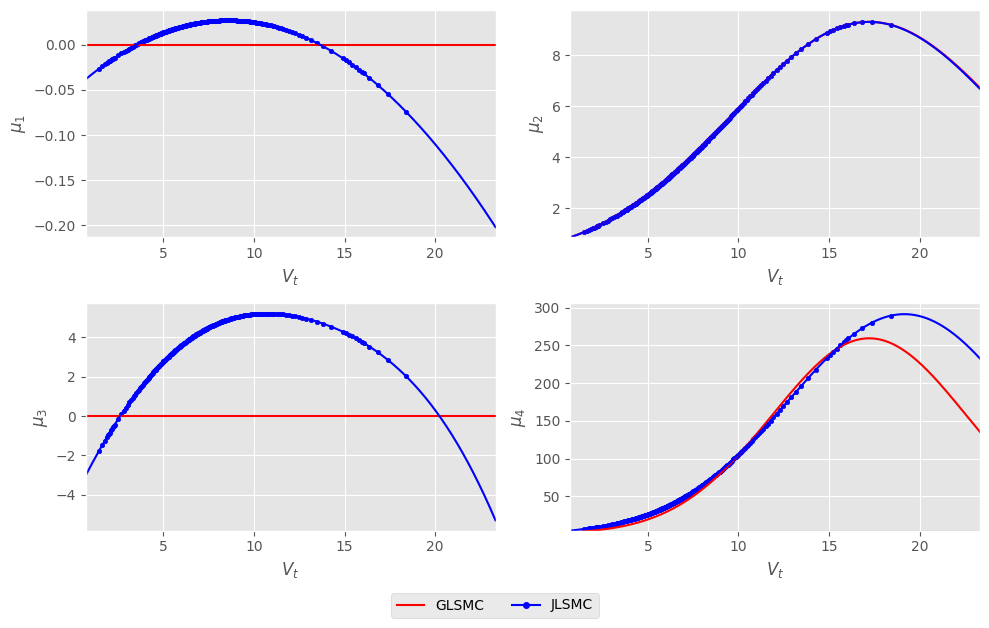

In [127]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].plot(mtm_test, mu1_test_glsmc, color=color_glsmc, label='GLSMC')
axs[0, 0].plot(mtm_test, mu1_test_jlsmc, color=color_jlsmc)
axs[0, 0].scatter(sample_quantiles, mu1_quant_jlsmc, color=color_jlsmc, s=10)
axs[0, 0].plot([None], [None], color=color_jlsmc, marker='o', markersize=4, label='JLSMC')
axs[0, 0].set_xlabel('$V_t$')
axs[0, 0].set_ylabel('$\\mu_1$')
axs[0, 0].set_xlim(np.min(mtm_test), np.max(mtm_test))
#axs[0, 0].set_ylim(-0.2, 0.2)

axs[0, 1].plot(mtm_test, mu2_test_glsmc, color=color_glsmc, label='GLSMC')
axs[0, 1].plot(mtm_test, mu2_test_jlsmc, color=color_jlsmc)
axs[0, 1].scatter(sample_quantiles, mu2_quant_jlsmc, color=color_jlsmc, s=10)
axs[0, 1].axhline(0, color='grey', linestyle='--')
axs[0, 1].fill_between(mtm_test, np.min(mu2_test_jlsmc)*np.ones_like(mtm_test), np.zeros_like(mtm_test), color='grey', alpha=0.5, label='impossible region')
axs[0, 1].plot([None], [None], color=color_jlsmc, marker='o', markersize=4, label='JLSMC')
axs[0, 1].set_xlabel('$V_t$')
axs[0, 1].set_ylabel('$\\mu_2$')
axs[0, 1].set_xlim(np.min(mtm_test), np.max(mtm_test))
axs[0, 1].set_ylim(bottom=np.min(mu2_test_jlsmc))

axs[1, 0].plot(mtm_test, mu3_test_glsmc, color=color_glsmc)
axs[1, 0].plot(mtm_test, mu3_test_jlsmc, color=color_jlsmc)
axs[1, 0].scatter(sample_quantiles, mu3_quant_jlsmc, color=color_jlsmc, s=10)
axs[1, 0].set_xlabel('$V_t$')
axs[1, 0].set_ylabel('$\\mu_3$')
axs[1, 0].set_xlim(np.min(mtm_test), np.max(mtm_test))
#axs[1, 0].set_ylim(-10, 10)

# kurtosis plot
axs[1, 1].plot(mtm_test, mu4_test_glsmc, color=color_glsmc)
axs[1, 1].plot(mtm_test, mu4_test_jlsmc, color=color_jlsmc)
axs[1, 1].scatter(sample_quantiles, mu4_quant_jlsmc, color=color_jlsmc, s=10)
axs[1, 1].axhline(0, color='grey', linestyle='--')
axs[1, 1].fill_between(mtm_test, np.min(mu4_test_jlsmc)*np.ones_like(mtm_test), np.zeros_like(mtm_test), color='grey', alpha=0.5, label='impossible region')
axs[1, 1].set_xlabel('$V_t$')
axs[1, 1].set_ylabel('$\\mu_4$')
axs[1, 1].set_xlim(np.min(mtm_test), np.max(mtm_test))
axs[1, 1].set_ylim(bottom=np.min(mu4_test_jlsmc))

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()

In [128]:
mu1_test_jlsmc  = mu1_test_jlsmc[mask_test_jlsmc]
mu2_test_jlsmc  = mu2_test_jlsmc[mask_test_jlsmc]
mu3_test_jlsmc  = mu3_test_jlsmc[mask_test_jlsmc]
mu4_test_jlsmc  = mu4_test_jlsmc[mask_test_jlsmc]

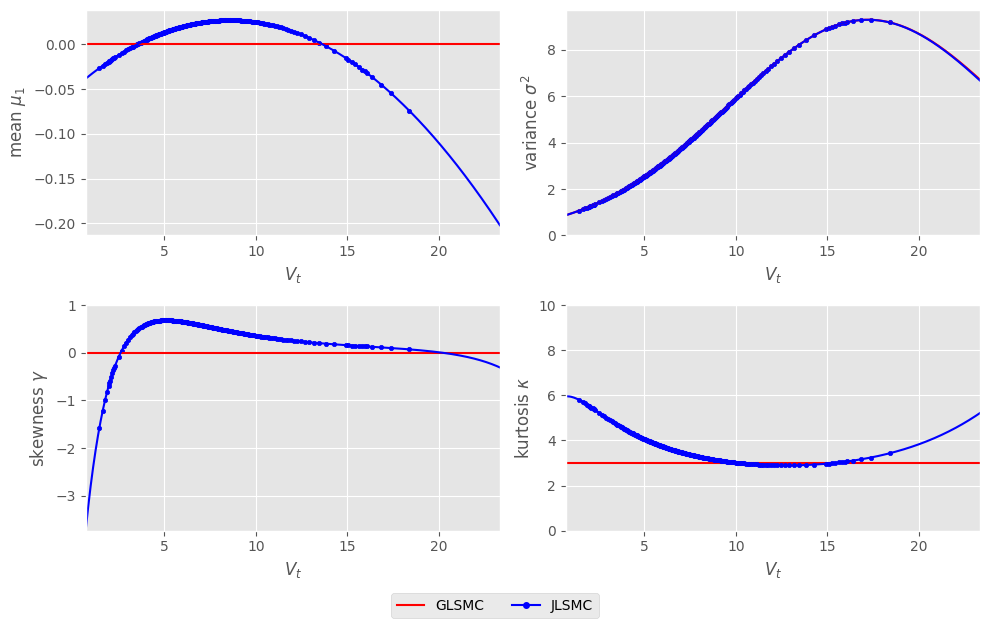

In [129]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# mean plot
axs[0, 0].plot(mtm_test[mask_test_jlsmc], mu1_test_glsmc[mask_test_jlsmc], color=color_glsmc, label='GLSMC')
axs[0, 0].plot(mtm_test[mask_test_jlsmc], mu1_test_jlsmc, color=color_jlsmc)
axs[0, 0].scatter(sample_quantiles, mu1_quant_jlsmc, color=color_jlsmc, s=10)
axs[0, 0].plot([None], [None], color=color_jlsmc, marker='o', markersize=4, label='JLSMC')
axs[0, 0].set_xlabel('$V_t$')
axs[0, 0].set_ylabel('mean $\\mu_1$')
axs[0, 0].set_xlim(np.min(mtm_test[mask_test_jlsmc]), np.max(mtm_test[mask_test_jlsmc]))

# variance plot
axs[0, 1].plot(mtm_test[mask_test_jlsmc], mu2_test_glsmc[mask_test_jlsmc], color=color_glsmc, label='GLSMC')
axs[0, 1].plot(mtm_test[mask_test_jlsmc], mu2_test_jlsmc, color=color_jlsmc)
axs[0, 1].scatter(sample_quantiles, mu2_quant_jlsmc, color=color_jlsmc, s=10)
axs[0, 1].plot([None], [None], color=color_jlsmc, marker='o', markersize=4, label='JLSMC')
axs[0, 1].set_xlabel('$V_t$')
axs[0, 1].set_ylabel('variance $\\sigma^2$')
axs[0, 1].set_xlim(np.min(mtm_test[mask_test_jlsmc]), np.max(mtm_test[mask_test_jlsmc]))
axs[0, 1].set_ylim(bottom=0)

# skewness plot
axs[1, 0].plot(mtm_test[mask_test_jlsmc], skew_test_glsmc[mask_test_jlsmc], color=color_glsmc)
axs[1, 0].plot(mtm_test[mask_test_jlsmc], skew_test_jlsmc, color=color_jlsmc)
axs[1, 0].scatter(sample_quantiles, skew_quant_jlsmc, color=color_jlsmc, s=10)
axs[1, 0].set_xlabel('$V_t$')
axs[1, 0].set_ylabel('skewness $\\gamma$')
axs[1, 0].set_xlim(np.min(mtm_test[mask_test_jlsmc]), np.max(mtm_test[mask_test_jlsmc]))
axs[1, 0].set_ylim(bottom=np.min(skew_test_jlsmc), top=1)

# kurtosis plot
axs[1, 1].plot(mtm_test[mask_test_jlsmc], kurt_test_glsmc[mask_test_jlsmc], color=color_glsmc)
axs[1, 1].plot(mtm_test[mask_test_jlsmc], kurt_test_jlsmc, color=color_jlsmc, zorder=2)
axs[1, 1].scatter(sample_quantiles, kurt_quant_jlsmc, color=color_jlsmc, s=10, zorder=2)
axs[1, 1].set_xlabel('$V_t$')
axs[1, 1].set_ylabel('kurtosis $\\kappa$')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_xlim(np.min(mtm_test[mask_test_jlsmc]), np.max(mtm_test[mask_test_jlsmc]))
axs[1, 1].set_ylim(bottom=0, top=10)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()

In [130]:
warnings.filterwarnings('ignore')

johnson_params_quant    = np.zeros((len(sample_quantiles), 4))
johnson_jtypes_quant    = np.zeros(len(sample_quantiles), dtype=int)
jtypes_map              = {'SL': 1, 'SU': 2, 'SB': 3, 'SN': 4, 'ST': 5}

for i in range(len(sample_quantiles)):
    coeffs, jtype, mess         = f_johnson_M(mu1_quant_jlsmc[i], sqrt(mu2_quant_jlsmc[i]), skew_quant_jlsmc[i], kurt_quant_jlsmc[i])
    if mess == '(b2 < b1+two)':
        print(f'Warning: impossible region for quantile {i}')
    johnson_params_quant[i, :]  = coeffs
    if np.any(np.isnan(coeffs)):
        print(f'Warning: NaN coefficients for quantile {i}')
        print(f'    (gamma, delta, xi, lambda)  = ({coeffs[0]:.2f}, {coeffs[1]:.2f}, {coeffs[2]:.2f}, {coeffs[3]:.2f})')
        print(f'    Johnson curve type          = {jtype}')
        print(f'    (mu1, mu2, skew, kurt) = ({mu1_quant_jlsmc[i]:.2f}, {mu2_quant_jlsmc[i]:.2f}, {skew_quant_jlsmc[i]:.2f}, {kurt_quant_jlsmc[i]:.2f})')
    johnson_jtypes_quant[i]     = jtypes_map[jtype]

mask                    = ~np.isnan(johnson_params_quant).any(axis=1)
johnson_params_quant    = johnson_params_quant[mask]
johnson_jtypes_quant    = johnson_jtypes_quant[mask]
sample_quantiles        = sample_quantiles[mask]

johnson_params_ref, jtype, _    = f_johnson_M(mu1_ref_jlsmc, sqrt(mu2_ref_jlsmc), skew_ref_jlsmc, kurt_ref_jlsmc)
johnson_jtype_ref               = jtypes_map[jtype]

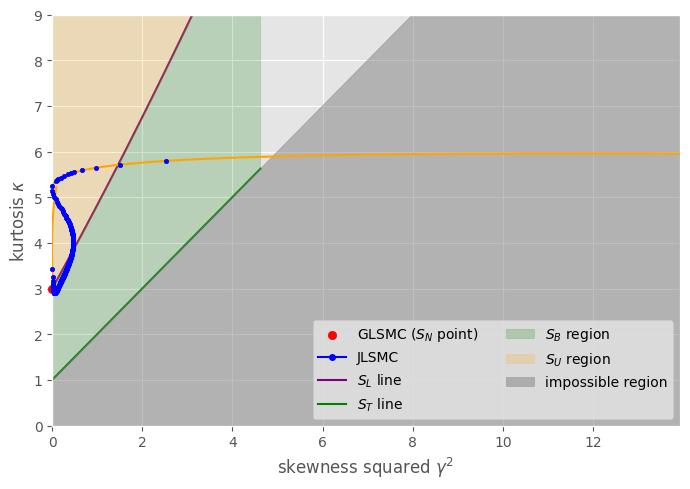

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter([skew_test_glsmc[0]**2], [kurt_test_glsmc[0]], color=color_glsmc, label='GLSMC ($S_N$ point)', zorder=3, clip_on=False)
# ax.plot(skew_test_jlsmc**2, kurt_test_jlsmc, color='red', zorder=3, clip_on=True)
ax.plot(skew_test_jlsmc**2, kurt_test_jlsmc, color='orange', zorder=3, clip_on=True)
ax.scatter(skew_quant_jlsmc**2, kurt_quant_jlsmc, color=color_jlsmc, s=10, zorder=3, clip_on=False)
ax.plot([None], [None], color=color_jlsmc, marker='o', markersize=4, label='JLSMC')
#ax.scatter(skew_quant_jlsmc[~mask]**2, kurt_quant_jlsmc[~mask], color='green', s=10, label='JLSMC quantile 64', zorder=3, clip_on=False)

omega       = np.linspace(1, 1.4, 100)
beta1_sl    = (omega-1) * (omega+2)**2
kurt_sl     = omega**4 + 2*omega**3 + 3*omega**2 - 3
ax.plot(beta1_sl, kurt_sl, color='purple', label='$S_L$ line', zorder=1)

#beta1_lim   = np.linspace(np.min(skew_test_jlsmc**2), np.max(skew_test_jlsmc**2), 100)
#kurt_lim    = 1 + beta1_lim
kurt_lim    = 1 + beta1_sl
ax.plot(beta1_sl, kurt_lim, color='green', label='$S_T$ line', zorder=1)
#interp_sl       = interp1d(beta1_sl, kurt_sl, bounds_error=False, fill_value="extrapolate")
#kurt_sl_interp  = interp_sl(beta1_lim)
#ax.fill_between(beta1_sl, kurt_lim, kurt_sl_interp, color='green', alpha=0.2, label='$S_B$ region', zorder=1)
ax.fill_between(beta1_sl, kurt_lim, kurt_sl, color='green', alpha=0.2, label='$S_B$ region', zorder=1)

max_kurt = max(np.max(kurt_test_jlsmc), np.max(kurt_test_glsmc), np.max(kurt_sl), np.max(kurt_lim))
ax.fill_between(beta1_sl, kurt_sl, max_kurt*np.ones_like(kurt_sl), color='orange', alpha=0.2, label='$S_U$ region', zorder=1)
beta1_lim   = np.linspace(np.min(skew_test_jlsmc**2), np.max(skew_test_jlsmc**2), 100)
kurt_lim2   = 1 + beta1_lim
ax.fill_between(beta1_lim, kurt_lim2, np.zeros_like(kurt_lim2), color='grey', alpha=0.5, label='impossible region', zorder=1)

ax.set_xlabel('skewness squared $\\gamma^2$')
ax.set_ylabel('kurtosis $\\kappa$')
ax.set_xlim(0, np.max(skew_test_jlsmc**2))
#ax.set_xlim(0, 2.5)
ax.set_ylim(0, 9)
ax.legend(ncol=2)
plt.tight_layout()
plt.show()

In [132]:
johnson_quantiles = np.zeros_like(sample_quantiles)

for i in range(len(sample_quantiles)):
    if johnson_jtypes_quant[i] == 1:
        johnson_quantiles[i] = lognorm.ppf(alpha, s=1/johnson_params_quant[i, 1], loc=johnson_params_quant[i, 2], scale=exp(-johnson_params_quant[i, 0]/johnson_params_quant[i, 1]))
    elif johnson_jtypes_quant[i] == 2:
        johnson_quantiles[i] = johnsonsu.ppf(alpha, a=johnson_params_quant[i, 0], b=johnson_params_quant[i, 1], loc=johnson_params_quant[i, 2], scale=johnson_params_quant[i, 3])
    elif (johnson_jtypes_quant[i] == 3) or (johnson_jtypes_quant[i] == 5):
        johnson_quantiles[i] = johnsonsb.ppf(alpha, a=johnson_params_quant[i, 0], b=johnson_params_quant[i, 1], loc=johnson_params_quant[i, 2], scale=johnson_params_quant[i, 3])
    elif johnson_jtypes_quant[i] == 4:
        johnson_quantiles[i] = norm.ppf(alpha, loc=johnson_params_quant[i, 2], scale=johnson_params_quant[i, 3])

In [133]:
x_pdfref = np.linspace(-10, 10, 1000)

if johnson_jtype_ref == 1:
    johnson_ref_quantile    = lognorm.ppf(alpha, s=1/johnson_params_ref[1], loc=johnson_params_ref[2], scale=exp(-johnson_params_ref[0]/johnson_params_ref[1]))
    johnson_y_pdfref        = lognorm.pdf(x_pdfref, s=1/johnson_params_ref[1], loc=johnson_params_ref[2], scale=exp(-johnson_params_ref[0]/johnson_params_ref[1]))
elif johnson_jtype_ref == 2:
    johnson_ref_quantile    = johnsonsu.ppf(alpha, a=johnson_params_ref[0], b=johnson_params_ref[1], loc=johnson_params_ref[2], scale=johnson_params_ref[3])
    johnson_y_pdfref        = johnsonsu.pdf(x_pdfref, a=johnson_params_ref[0], b=johnson_params_ref[1], loc=johnson_params_ref[2], scale=johnson_params_ref[3])
elif (johnson_jtype_ref == 3) or (johnson_jtype_ref == 5):
    johnson_ref_quantile    = johnsonsb.ppf(alpha, a=johnson_params_ref[0], b=johnson_params_ref[1], loc=johnson_params_ref[2], scale=johnson_params_ref[3])
    johnson_y_pdfref        = johnsonsb.pdf(x_pdfref, a=johnson_params_ref[0], b=johnson_params_ref[1], loc=johnson_params_ref[2], scale=johnson_params_ref[3])
elif johnson_jtype_ref == 4:
    johnson_ref_quantile    = norm.ppf(alpha, loc=johnson_params_ref[2], scale=johnson_params_ref[3])
    johnson_y_pdfref        = norm.pdf(x_pdfref, loc=johnson_params_ref[2], scale=johnson_params_ref[3])

glsmc_ref_quantile  = norm.ppf(alpha, loc=0, scale=np.sqrt(mu2_ref_glsmc))
glsmc_y_pdfref      = norm.pdf(x_pdfref, loc=0, scale=np.sqrt(mu2_ref_glsmc))

In [134]:
R_jlsmc         = 4
Xvar_jlsmc      = np.column_stack([eval_genlaguerre(r, 0, sample_quantiles) for r in range(R_jlsmc+1)])
yvar_jlsmc      = johnson_quantiles
Xvar_test_jlsmc = np.column_stack([eval_genlaguerre(r, 0, mtm_test) for r in range(R_jlsmc+1)])
model_jlsmc     = LinearRegression(fit_intercept=False)
model_jlsmc.fit(Xvar_jlsmc, yvar_jlsmc)
yhat_var_jlsmc  = model_jlsmc.predict(Xvar_test_jlsmc)

In [135]:
'''
M_outer_nested  = 1000
M_inner         = 100000
bin_size        = M // M_outer_nested
sorted_inds     = np.argsort(mtm_paths[:, ind_tref])
selec_inds      = np.array([sorted_inds[i*bin_size + bin_size//2] for i in range(M_outer_nested)])
S_paths_selec   = S_paths[selec_inds, :]
mtm_paths_selec = mtm_paths[selec_inds, :]

S_paths_nested      = np.zeros((M_outer_nested, M_inner, ind_tdelta-ind_tref+1))
mtm_nested_paths    = np.zeros((M_outer_nested, M_inner, ind_tdelta-ind_tref+1))
mtm_diff_val = np.zeros((M_outer_nested, M_inner))
for m in range(M_outer_nested):
    S_paths_nested[m, :, :]     = gen_S(S_paths_selec[m, ind_tref], M_inner, ind_tdelta-ind_tref)
    mtm_nested_paths[m, :, 1:]  = gen_mtm_put(S_paths_nested[m, :, 1:], time_grid[ind_tref+1:ind_tdelta+1])
    mtm_nested_paths[m, :, 0]   = mtm_paths_selec[m, ind_tref]
    mtm_diff_val[m, :]          = mtm_nested_paths[m, :, -1] - mtm_nested_paths[m, :, 0]

quantiles_nested = np.percentile(mtm_diff_val, 100*alpha, axis=1)
'''

'\nM_outer_nested  = 1000\nM_inner         = 100000\nbin_size        = M // M_outer_nested\nsorted_inds     = np.argsort(mtm_paths[:, ind_tref])\nselec_inds      = np.array([sorted_inds[i*bin_size + bin_size//2] for i in range(M_outer_nested)])\nS_paths_selec   = S_paths[selec_inds, :]\nmtm_paths_selec = mtm_paths[selec_inds, :]\n\nS_paths_nested      = np.zeros((M_outer_nested, M_inner, ind_tdelta-ind_tref+1))\nmtm_nested_paths    = np.zeros((M_outer_nested, M_inner, ind_tdelta-ind_tref+1))\nmtm_diff_val = np.zeros((M_outer_nested, M_inner))\nfor m in range(M_outer_nested):\n    S_paths_nested[m, :, :]     = gen_S(S_paths_selec[m, ind_tref], M_inner, ind_tdelta-ind_tref)\n    mtm_nested_paths[m, :, 1:]  = gen_mtm_put(S_paths_nested[m, :, 1:], time_grid[ind_tref+1:ind_tdelta+1])\n    mtm_nested_paths[m, :, 0]   = mtm_paths_selec[m, ind_tref]\n    mtm_diff_val[m, :]          = mtm_nested_paths[m, :, -1] - mtm_nested_paths[m, :, 0]\n\nquantiles_nested = np.percentile(mtm_diff_val, 100*al

In [136]:
S_test              = np.linspace(np.min(S_paths[:, ind_tref]), np.max(S_paths[:, ind_tref]), 1000)
quantiles_theo_S    = S_test * exp((r-0.5*sigma**2)*delta + sigma*sqrt(delta)*norm.ppf(1-alpha))
mtm_theo            = gen_mtm_put(quantiles_theo_S.reshape(-1, 1), time_grid[ind_tdelta:ind_tdelta+1]).reshape(-1)
mtm_theo_bis        = gen_mtm_put(S_test.reshape(-1, 1), time_grid[ind_tref:ind_tref+1]).reshape(-1)
quantiles_theo      = mtm_theo - mtm_theo_bis

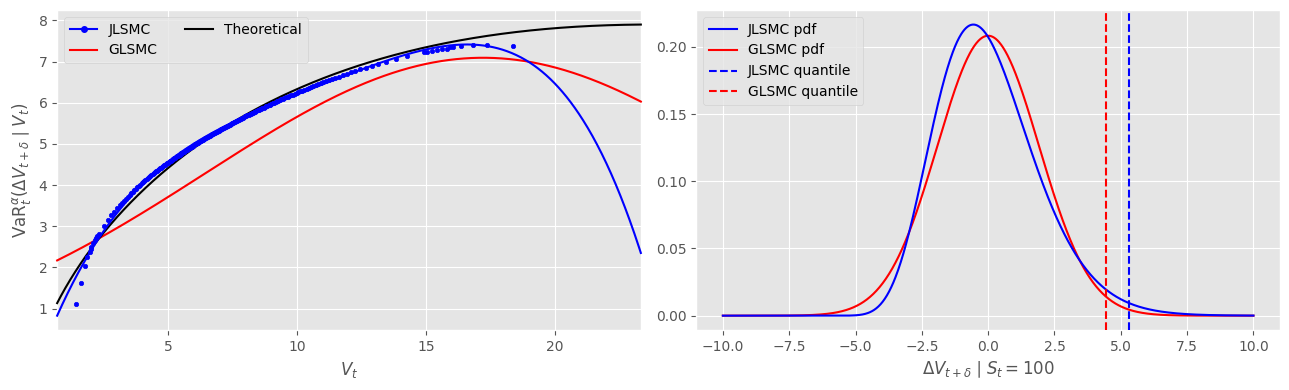

In [137]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

axs[0].plot(mtm_test, yhat_var_jlsmc, color=color_jlsmc, zorder=4, clip_on=False)
axs[0].scatter(sample_quantiles, johnson_quantiles, color=color_jlsmc, s=10, zorder=5, clip_on=False)
axs[0].plot([None], [None], color=color_jlsmc, marker='o', markersize=4, label='JLSMC')
axs[0].plot(mtm_test, norm.ppf(alpha, loc=0, scale=np.sqrt(mu2_test_glsmc)), color=color_glsmc, label='GLSMC', zorder=3, clip_on=False)
axs[0].plot(mtm_theo_bis, quantiles_theo, color='black', label='Theoretical', zorder=3, clip_on=False)
#axs[0].scatter(mtm_paths_selec[:, ind_tref], quantiles_nested, color='black', s=30, zorder=1, clip_on=False, facecolors='none', label='Nested MC')
axs[0].legend(ncol=2)
axs[0].set_xlabel('$V_t$')
axs[0].set_ylabel('$\\text{VaR}_t^\\alpha\\left(\\Delta V_{t+\\delta} \\mid V_t \\right)$')
axs[0].set_xlim(np.min(mtm_test), np.max(mtm_test))

axs[1].plot(x_pdfref, johnson_y_pdfref, color=color_jlsmc, label='JLSMC pdf', zorder=4, clip_on=False)
axs[1].plot(x_pdfref, glsmc_y_pdfref, color=color_glsmc, label='GLSMC pdf', zorder=3, clip_on=False)
axs[1].axvline(x=johnson_ref_quantile, color=color_jlsmc, linestyle='--', label='JLSMC quantile', zorder=5, clip_on=False)
axs[1].axvline(x=glsmc_ref_quantile, color=color_glsmc, linestyle='--', label='GLSMC quantile', zorder=5, clip_on=False)
axs[1].set_xlabel('$\\Delta V_{t+\\delta} \\mid S_t = 100$')
axs[1].legend()

plt.tight_layout()
plt.show()

array([7.89977703, 7.89945991, 7.89910136, 7.8987014 , 7.89826004,
       7.89777731, 7.89725322, 7.89668779, 7.89608103, 7.89543298,
       7.89474364, 7.89401305, 7.89324122, 7.89242818, 7.89157396,
       7.89067858, 7.88974206, 7.88876444, 7.88774575, 7.886686  ,
       7.88558524, 7.8844435 , 7.8832608 , 7.88203718, 7.88077268,
       7.87946733, 7.87812116, 7.87673421, 7.87530652, 7.87383813,
       7.87232907, 7.87077939, 7.86918913, 7.86755833, 7.86588702,
       7.86417527, 7.8624231 , 7.86063057, 7.85879772, 7.85692459,
       7.85501125, 7.85305772, 7.85106407, 7.84903034, 7.84695659,
       7.84484286, 7.84268921, 7.8404957 , 7.83826237, 7.83598928,
       7.83367649, 7.83132406, 7.82893203, 7.82650048, 7.82402945,
       7.82151902, 7.81896923, 7.81638016, 7.81375185, 7.81108439,
       7.80837782, 7.80563222, 7.80284765, 7.80002417, 7.79716185,
       7.79426077, 7.79132098, 7.78834256, 7.78532557, 7.78227009,
       7.77917619, 7.77604394, 7.77287342, 7.76966469, 7.76641